# A  working model that implements a statistical arbitrage strategy using machine learning (for education purposes only)

In [1]:
pip install yfinance pandas numpy scikit-learn statsmodels matplotlib seaborn


Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.6/94.6 KB 142.4 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 417.5 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 524.3 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 607.5 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 791.1 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 955.1 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 KB 652.8 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 508.0/508.0 KB 344.1 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 158.7 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 310.7 kB/s eta 0:00:0000:0100:01
  Installing buil

In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import coint
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
# Define the ticker symbols
ticker1 = 'AAPL'  # Apple Inc.
ticker2 = 'MSFT'  # Microsoft Corporation

# Define the date range
start_date = '2015-01-01'
end_date = '2023-10-01'

# Download the data
data1 = yf.download(ticker1, start=start_date, end=end_date)
data2 = yf.download(ticker2, start=start_date, end=end_date)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
# Use the adjusted closing price
data1 = data1['Adj Close']
data2 = data2['Adj Close']

# Combine the data into a single DataFrame
df = pd.DataFrame({ticker1: data1, ticker2: data2})

# Drop rows with missing values
df.dropna(inplace=True)


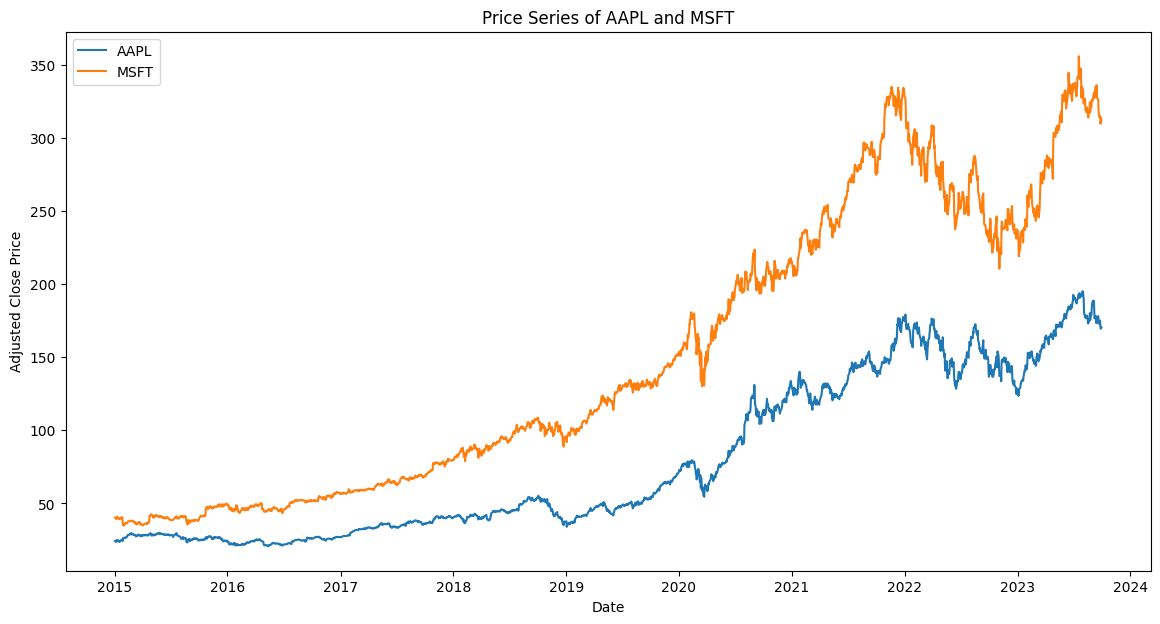

In [5]:
plt.figure(figsize=(14, 7))
plt.plot(df[ticker1], label=ticker1)
plt.plot(df[ticker2], label=ticker2)
plt.title('Price Series of AAPL and MSFT')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()


In [6]:
# Perform the cointegration test
score, pvalue, _ = coint(df[ticker1], df[ticker2])
print(f'Cointegration test p-value: {pvalue:.4f}')


Cointegration test p-value: 0.1100


In [7]:
# Reshape data for regression
X = df[ticker2].values.reshape(-1, 1)  # Independent variable
y = df[ticker1].values  # Dependent variable

# Create and fit the model
model = LinearRegression()
model.fit(X, y)

# Extract the hedge ratio
hedge_ratio = model.coef_[0]
print(f'Hedge Ratio: {hedge_ratio:.4f}')


Hedge Ratio: 0.5558


In [8]:
# Calculate the spread
df['Spread'] = df[ticker1] - hedge_ratio * df[ticker2]


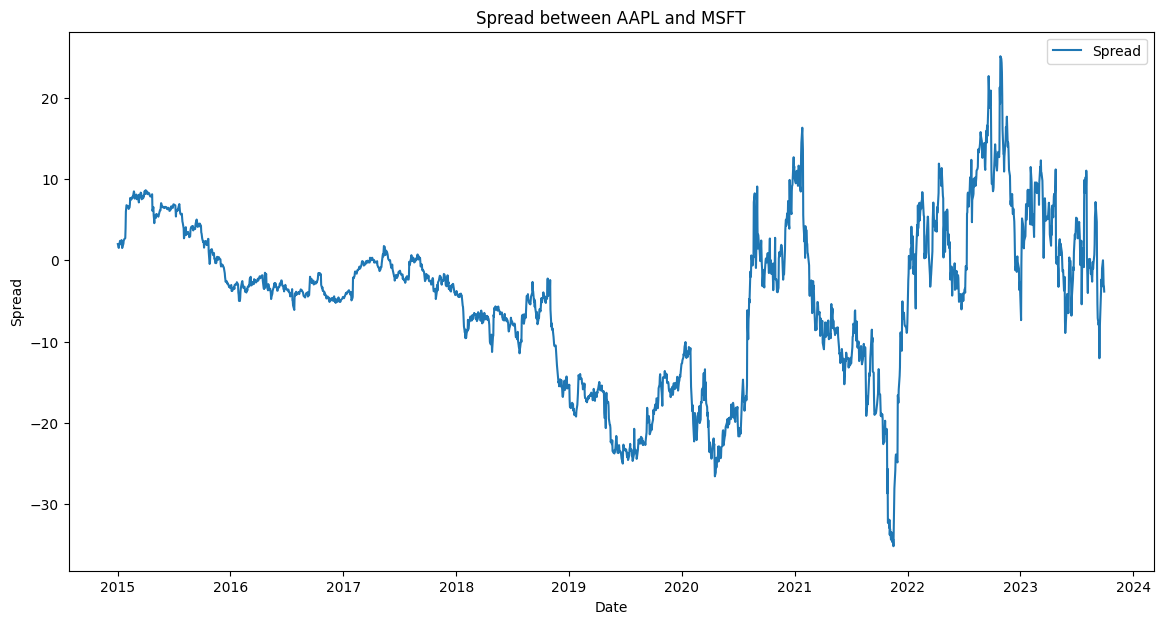

In [9]:
plt.figure(figsize=(14, 7))
plt.plot(df['Spread'], label='Spread')
plt.title('Spread between AAPL and MSFT')
plt.xlabel('Date')
plt.ylabel('Spread')
plt.legend()
plt.show()


In [10]:
# Calculate rolling mean and standard deviation
window = 30  # Rolling window size
df['Spread_Mean'] = df['Spread'].rolling(window=window).mean()
df['Spread_STD'] = df['Spread'].rolling(window=window).std()

# Calculate z-score
df['Z_Score'] = (df['Spread'] - df['Spread_Mean']) / df['Spread_STD']


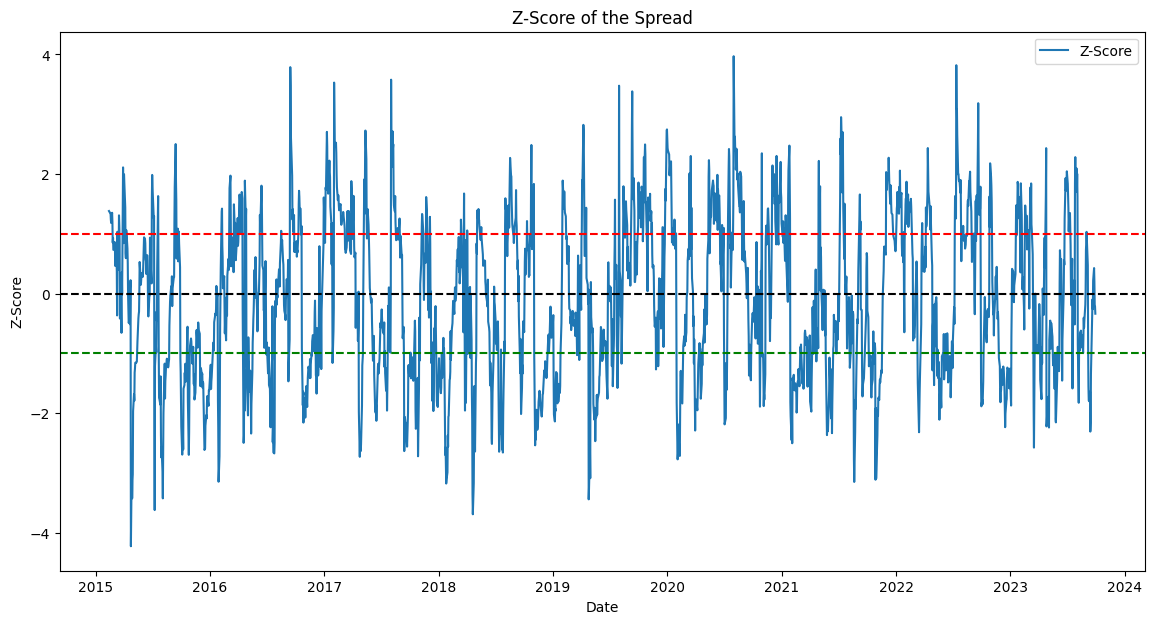

In [11]:
plt.figure(figsize=(14, 7))
plt.plot(df['Z_Score'], label='Z-Score')
plt.axhline(0, color='black', linestyle='--')
plt.axhline(1, color='red', linestyle='--')
plt.axhline(-1, color='green', linestyle='--')
plt.title('Z-Score of the Spread')
plt.xlabel('Date')
plt.ylabel('Z-Score')
plt.legend()
plt.show()


In [12]:
# Entry and exit thresholds
entry_threshold = 1.0
exit_threshold = 0.0

# Initialize signals
df['Long_Signal'] = 0
df['Short_Signal'] = 0

# Generate signals
df['Long_Signal'] = np.where(df['Z_Score'] <= -entry_threshold, 1, 0)
df['Short_Signal'] = np.where(df['Z_Score'] >= entry_threshold, -1, 0)

# Combine signals
df['Positions'] = df['Long_Signal'] + df['Short_Signal']


In [13]:
# Calculate daily returns
df['Return_AAPL'] = df[ticker1].pct_change()
df['Return_MSFT'] = df[ticker2].pct_change()

# Shift positions to align with returns
df['Positions'] = df['Positions'].shift(1)

# Strategy returns
df['Strategy_Return'] = df['Positions'] * (df['Return_AAPL'] - hedge_ratio * df['Return_MSFT'])
df['Cumulative_Strategy_Return'] = (1 + df['Strategy_Return'].fillna(0)).cumprod() - 1


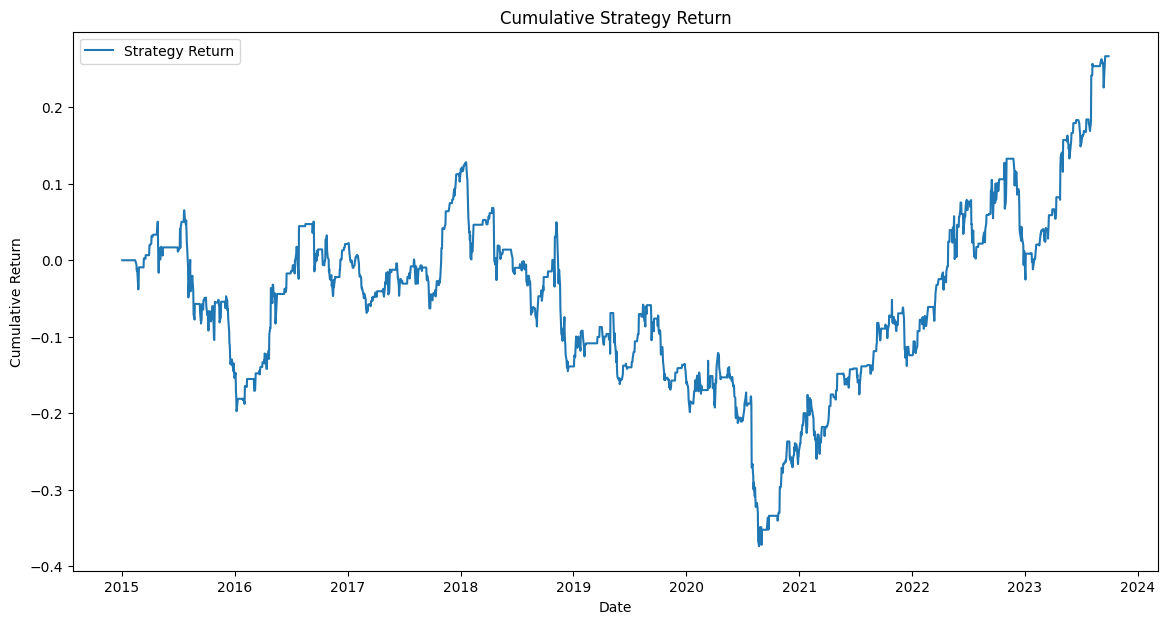

In [14]:
plt.figure(figsize=(14, 7))
plt.plot(df['Cumulative_Strategy_Return'], label='Strategy Return')
plt.title('Cumulative Strategy Return')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()


In [15]:
# Annualized Return
annualized_return = df['Strategy_Return'].mean() * 252
print(f'Annualized Return: {annualized_return:.2%}')

# Annualized Volatility
annualized_volatility = df['Strategy_Return'].std() * np.sqrt(252)
print(f'Annualized Volatility: {annualized_volatility:.2%}')

# Sharpe Ratio
risk_free_rate = 0.01  # Assume 1% annual risk-free rate
sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility
print(f'Sharpe Ratio: {sharpe_ratio:.2f}')

# Maximum Drawdown
df['Cumulative_Max'] = df['Cumulative_Strategy_Return'].cummax()
df['Drawdown'] = df['Cumulative_Max'] - df['Cumulative_Strategy_Return']
max_drawdown = df['Drawdown'].max()
print(f'Maximum Drawdown: {max_drawdown:.2%}')


Annualized Return: 3.94%
Annualized Volatility: 15.70%
Sharpe Ratio: 0.19
Maximum Drawdown: 50.17%


In [16]:
# Assume a transaction cost per trade
transaction_cost = 0.0005  # 0.05%

# Calculate trade entries and exits
df['Trades'] = df['Positions'].diff().abs()
df['Transaction_Costs'] = df['Trades'] * transaction_cost

# Adjust strategy returns
df['Strategy_Return_Net'] = df['Strategy_Return'] - df['Transaction_Costs']
df['Cumulative_Strategy_Return_Net'] = (1 + df['Strategy_Return_Net'].fillna(0)).cumprod() - 1


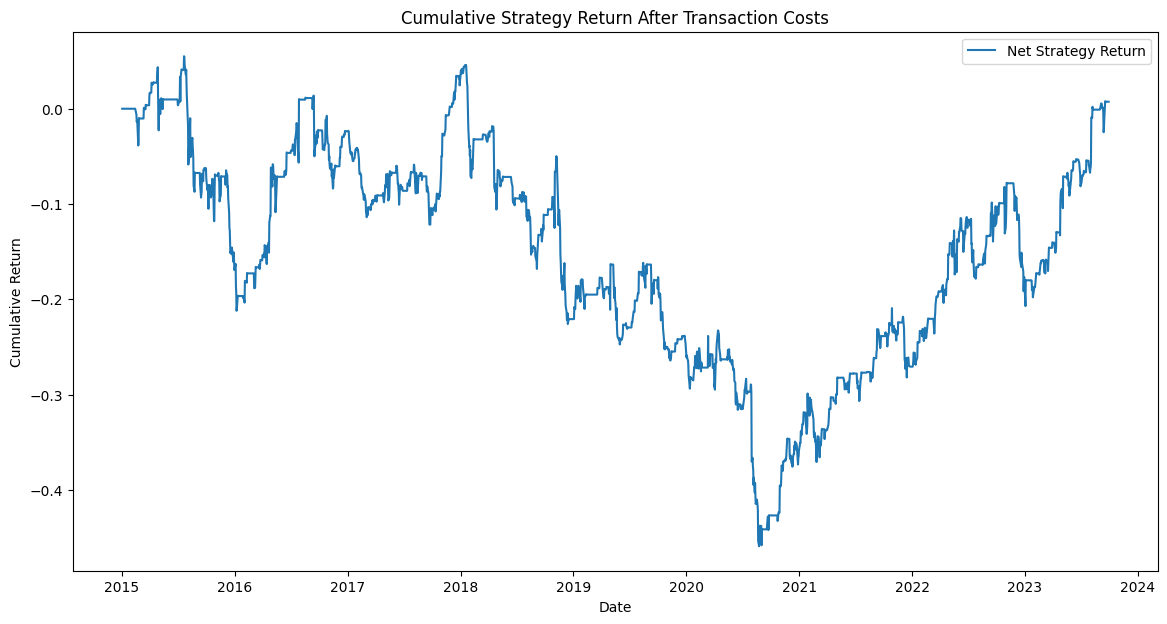

In [17]:
plt.figure(figsize=(14, 7))
plt.plot(df['Cumulative_Strategy_Return_Net'], label='Net Strategy Return')
plt.title('Cumulative Strategy Return After Transaction Costs')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()
